<a href="https://colab.research.google.com/github/aguzel/computational_imaging/blob/main/image_color_space.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from PIL import Image
import numpy as np_cpu
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from torchvision import transforms

%matplotlib inline

# GPU Checked
is_cuda = torch.cuda.is_available()
if torch.cuda.is_available():
    print("GPU is active")
else:
    print("Only CPU is active")

GPU is active


In [2]:
class image_color_space():
    """
    A class for manipulating color space of an image.
    """

    def __init__(self,image_location):
      self.image_location = image_location
      
    

    def load_image(self):
      """
      Definition to load an image from a given location as a Numpy array.
      Parameters
      ----------
      fn           : str
                     Filename.
      Returns
      ----------
      image        :  NCHW
                      Image loaded as a Numpy array.
      """
      image = Image.open(self.image_location)
      image = np_cpu.array(image)
      image = torch.from_numpy(image)
      image = torch.swapaxes(image,0,2)
      image = image.unsqueeze(0)
      return image
    
    def rgb_2_ycrcb(self,image):
        """
        Converts an image from RGB colourspace to YCrCb colourspace.
        Parameters
        ----------
        image   : torch.tensor
                    Input image. Should be an RGB floating-point image with values in the range [0, 1]
                    Should be in NCHW format.
        Returns
        -------
        ycrcb   : torch.tensor
                    Image converted to YCrCb colourspace.
        """
        ycrcb = torch.zeros(image.size()).to(image.device)
        ycrcb[:, 0, :, :] = 0.299 * image[:, 0, :, :] + 0.587 * \
            image[:, 1, :, :] + 0.114 * image[:, 2, :, :]
        ycrcb[:, 1, :, :] = 0.5 + 0.713 * (image[:, 0, :, :] - ycrcb[:, 0, :, :])
        ycrcb[:, 2, :, :] = 0.5 + 0.564 * (image[:, 2, :, :] - ycrcb[:, 0, :, :])
        return ycrcb

    def ycrcb_2_rgb(self,image):
        """
        Converts an image from YCrCb colourspace to RGB colourspace.
        Parameters
        ----------
        image   : torch.tensor
                    Input image. Should be a YCrCb floating-point image with values in the range [0, 1]
                    Should be in NCHW format.
        Returns
        -------
        rgb     : torch.tensor
                    Image converted to RGB colourspace.
        """
        rgb = torch.zeros(image.size(), device=image.device)
        rgb[:, 0, :, :] = image[:, 0, :, :] + 1.403 * (image[:, 1, :, :] - 0.5)
        rgb[:, 1, :, :] = image[:, 0, :, :] - 0.714 * \
            (image[:, 1, :, :] - 0.5) - 0.344 * (image[:, 2, :, :] - 0.5)
        rgb[:, 2, :, :] = image[:, 0, :, :] + 1.773 * (image[:, 2, :, :] - 0.5)
        return rgb

    def rgb_2_hsv(self,image,eps):
        image = image / 255.0
        hue = torch.Tensor(image.shape[0], image.shape[2], image.shape[3]).to(image.device)

        hue[ image[:,2]==image.max(1)[0] ] = 4.0 + ( (image[:,0]-image[:,1]) / ( image.max(1)[0] - image.min(1)[0] + eps) ) [ image[:,2]==image.max(1)[0] ]
        hue[ image[:,1]==image.max(1)[0] ] = 2.0 + ( (image[:,2]-image[:,0]) / ( image.max(1)[0] - image.min(1)[0] + eps) ) [ image[:,1]==image.max(1)[0] ]
        hue[ image[:,0]==image.max(1)[0] ] = (0.0 + ( (image[:,1]-image[:,2]) / ( image.max(1)[0] - image.min(1)[0] + eps) ) [ image[:,0]==image.max(1)[0] ]) % 6

        hue[image.min(1)[0]==image.max(1)[0]] = 0.0
        hue = hue/6

        saturation = ( image.max(1)[0] - image.min(1)[0] ) / ( image.max(1)[0] + eps )
        saturation[ image.max(1)[0]==0 ] = 0

        value = image.max(1)[0]
        hue = hue.unsqueeze(1)
        saturation = saturation.unsqueeze(1)
        value = value.unsqueeze(1)
        hsv = torch.cat([hue,saturation,value], dim =1)
        return hsv  


    def hsv_2_rgb(self,hsv_image):

        h = hsv_image[:,0,:,:]
        s = hsv_image[:,1,:,:]
        v = hsv_image[:,2,:,:]
        
        h = h%1
        s = torch.clamp(s,0,1)
        v = torch.clamp(v,0,1)

        r = torch.zeros_like(h)
        g = torch.zeros_like(h)
        b = torch.zeros_like(h)

        hi = torch.floor(h * 6)
        f = h * 6 - hi
        p = v * (1 - s)
        q = v * (1 - (f * s))
        t = v * (1 - ((1 - f) * s))

        hi0 = hi == 0
        hi1 = hi == 1
        hi2 = hi == 2
        hi3 = hi == 3
        hi4 = hi == 4 
        hi5 = hi == 5

        r[hi0] = v[hi0]
        g[hi0] = t[hi0]
        b[hi0] = p[hi0]

        r[hi1] = q[hi1]
        g[hi1] = v[hi1]
        b[hi1] = p[hi1]
        
        r[hi2] = p[hi2]
        g[hi2] = v[hi2]
        b[hi2] = t[hi2]

        r[hi3] = p[hi3]
        g[hi3] = q[hi3]
        b[hi3] = v[hi3]

        r[hi4] = t[hi4]
        g[hi4] = p[hi4]
        b[hi4] = v[hi4]

        r[hi5] = v[hi5]
        g[hi5] = p[hi5]
        b[hi5] = q[hi5]

        r = r.unsqueeze(1)
        g = g.unsqueeze(1)
        b = b.unsqueeze(1)

        rgb_image = torch.cat([r,g,b], dim = 1)
        return rgb_image

In [3]:
color_space = image_color_space('/content/parrot.png')
image = color_space.load_image()
hsv_tensor_image = color_space.rgb_2_hsv(image,1e-8)
rgb_tensor_image = color_space.hsv_2_rgb(hsv_tensor_image)
ycrcb_tensor_image = color_space.rgb_2_ycrcb(rgb_tensor_image)

In [4]:
def plot_image(image):
  numpy_image = image.cpu().detach().numpy()
  numpy_image = numpy_image.squeeze(0)
  numpy_image = numpy_image.swapaxes(0,2)
  plt.imshow(numpy_image)

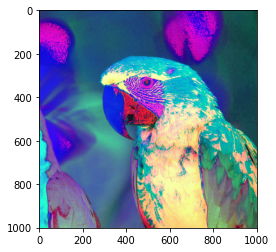

In [5]:
plot_image(hsv_tensor_image) 

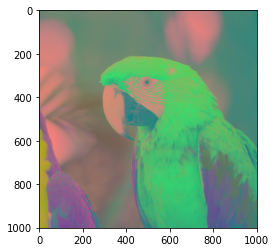

In [6]:
plot_image(ycrcb_tensor_image) 

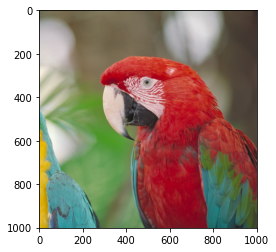

In [7]:
plot_image(rgb_tensor_image)

In [15]:
def reconstruct(image, iterations):

    '''
    Image reconstruction via MSELoss minimization 

    Ax = b where;
    A = Input image (zeros)
    b = target image 
    x = parameter to be optimised for min. L2 loss
    '''
    
    criterion = torch.nn.MSELoss()
    target = image
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    x = torch.autograd.Variable(torch.diag(torch.ones(1001)), requires_grad=True) #x
    input = torch.rand_like(target) #A 
    optimizer = optim.Adam(params=[{'params': [x]}], lr = 0.001) 
    x.to(device)
    input.to(device)
    target.to(device)

    opt_loss =[]
    optimisation_loss = 0.0

    for i in range(0, iterations):
      optimizer.zero_grad()
      output = torch.matmul(input,x)
      loss = criterion(output, target)
      loss.backward()
      optimizer.step()      
      optimisation_loss += float(loss)
      
       
      
      if i % 5 == 4:
        print('iter:%5d loss:%.3f' %(i + 1, loss.item()))        
      opt_loss.append(loss.item())
      
    print("-----Finished----")           
    return x, opt_loss

In [22]:
#x_hsv, hsv_loss = reconstruct(hsv_tensor_image,1000)
#x_rgb, rgb_loss = reconstruct(rgb_tensor_image,1000)
x_ycrcb, ycrcb_loss = reconstruct(ycrcb_tensor_image,10000)

iter:    5 loss:0.212
iter:   10 loss:0.156
iter:   15 loss:0.124
iter:   20 loss:0.106
iter:   25 loss:0.100
iter:   30 loss:0.098
iter:   35 loss:0.098
iter:   40 loss:0.096
iter:   45 loss:0.095
iter:   50 loss:0.094
iter:   55 loss:0.093
iter:   60 loss:0.092
iter:   65 loss:0.091
iter:   70 loss:0.089
iter:   75 loss:0.088
iter:   80 loss:0.087
iter:   85 loss:0.086
iter:   90 loss:0.085
iter:   95 loss:0.084
iter:  100 loss:0.083
iter:  105 loss:0.082
iter:  110 loss:0.081
iter:  115 loss:0.080
iter:  120 loss:0.079
iter:  125 loss:0.078
iter:  130 loss:0.077
iter:  135 loss:0.076
iter:  140 loss:0.075
iter:  145 loss:0.074
iter:  150 loss:0.074
iter:  155 loss:0.073
iter:  160 loss:0.072
iter:  165 loss:0.071
iter:  170 loss:0.070
iter:  175 loss:0.069
iter:  180 loss:0.068
iter:  185 loss:0.067
iter:  190 loss:0.067
iter:  195 loss:0.066
iter:  200 loss:0.065
iter:  205 loss:0.064
iter:  210 loss:0.064
iter:  215 loss:0.063
iter:  220 loss:0.062
iter:  225 loss:0.061
iter:  230

ValueError: ignored

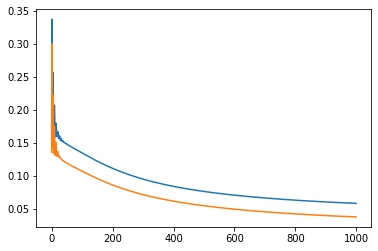

In [23]:
plt.plot(range(1000), hsv_loss, label='hsv loss')
plt.plot(range(1000), rgb_loss, label='rgb loss')
plt.plot(range(1000), ycrcb_loss, label='ycrcb loss')
plt.xlabel('iterations')
plt.ylabel('MSE loss')
plt.legend(loc='upper right')
plt.show()

In [24]:
# all images converge to rgb numpy for plotting
target = rgb_tensor_image
input = torch.ones_like(target)
criterion = torch.nn.MSELoss()

# HSV to RGB
hsv_output = torch.matmul(input,x_hsv)
hsv_output_RGB = color_space.hsv_2_rgb(hsv_output)

#YCRCB to RGB
ycrcb_output = torch.matmul(input,x_ycrcb)
ycrcb_output_RGB = color_space.ycrcb_2_rgb(ycrcb_output)

#RGB to RGB
rgb_output_RGB = torch.matmul(input,x_rgb)

In [25]:
def numpy_image(image):

  image_out = image.squeeze(0)
  image_out = image_out.swapaxes(0,2)
  image_out.size()

  np_cpu_image = image_out.cpu().detach().numpy()
  return np_cpu_image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 1000.5, 1000.5, -0.5)

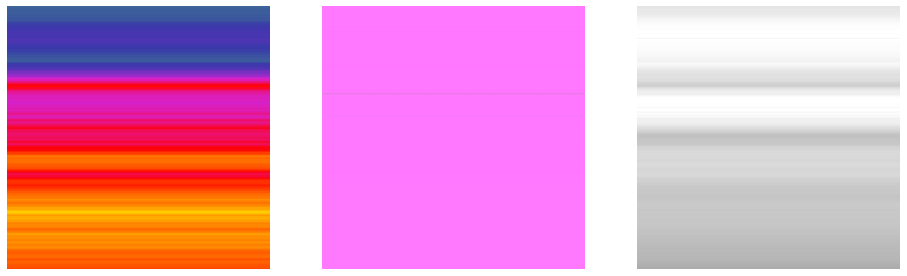

In [26]:
hsv_based_np_image = numpy_image(hsv_output_RGB) #HSV based output 
ycrcb_based_np_image = numpy_image(ycrcb_output_RGB) #YCRCB based output 
rgb_based_np_image = numpy_image(rgb_output_RGB) #RGB based output


fig, (ax1, ax2, ax3) =  plt.subplots(1, 3,figsize=(16,8))
ax1.imshow(hsv_based_np_image)
ax2.imshow(ycrcb_based_np_image)
ax3.imshow(rgb_based_np_image)
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')

